# Memory task initial data exploration
## Matt Oberhardt



### Imports & API calls:

In [1]:
import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
from numpy import nan
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ranksums
%load_ext autoreload
%matplotlib inline  
# from pandas import DataFrame, Series
np.set_printoptions(threshold='nan') # so that i can print as many lines as i want

sns.set(style="darkgrid", color_codes=True, font_scale=1.5)



In [2]:
import memorytools as mt

### Load up the memory & demographic data:

In [3]:
# initialize environment:
synuser = os.environ['SYNAPSE_USER']
synpass = os.environ['SYNAPSE_PASS']
mt.loadSynapseRecordsFromScratch = False
syn, memory, memorysyn, filePaths, demographics, demosyn, data = mt.create_memory_environment(synuser, synpass)
data = mt.filter_data_for_popular_phones(data)


Welcome, Matthew Oberhardt!
(phones are now filtered for only the most popular ones)


In [4]:
# pull out features from games:
fromFile = True#False
toSave = False#True
data = mt.add_memory_game_features_to_data(filePaths, data, fromFile = fromFile, toSave=toSave, outFileName='memory_data_with_features.p')

memory features loaded from file: memory_data_with_features.p (input data was ignored)


In [5]:
# add memory composite features:
data = mt.add_composite_features_to_data(data)

Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


### Visualize the memory data:

#### Columns:

In [6]:
# columns:
for col in data.columns:
    print col

recordId
healthCode
createdOn
appVersion
phoneInfo
game_score
game_numGames
game_numFails
game_startDate
game_endDate
game_records
medTimepoint
game_records_txt
recordId_demographic
createdOn_demographic
appVersion_demographic
phoneInfo_demographic
age
isCaretaker
brainStim
diagYear
education
employment
gender
healthHistory
healthcareProvider
homeUsage
lastSmoked
maritalStatus
medicalUsage
medicalUsageYesterday
medicationStartYear
onsetYear
packsPerDay
pastParticipation
phoneUsage
professionalDiagnosis
race
smartphone
smoked
surgery
videoUsage
yearsSmoking
gamesdata
16_latency
16_gamescore
16_successful
16_meanDt
16_meandist
16_gamesize
16_meanunsuccessfuldist
16_meansuccessfuldist
16_numunsuccesses
16_numsuccesses
16_firstdist
9_latency
9_gamescore
9_successful
9_meanDt
9_meandist
9_gamesize
9_meanunsuccessfuldist
9_meansuccessfuldist
9_numunsuccesses
9_numsuccesses
9_firstdist
4_latency
4_gamescore
4_successful
4_meanDt
4_meandist
4_gamesize
4_meanunsuccessfuldist
4_meansuccessfuldis

In [7]:
# How many nans in each column?
mt.display_num_nulls_per_column(data)



Number of nulls per column:

recordId                      0
played_game4                  0
gamesdata                     0
phoneInfo_demographic         0
appVersion_demographic        0
createdOn_demographic         0
recordId_demographic          0
game_records                  0
game_endDate                  0
game_records_txt              0
game_numFails                 0
game_numGames                 0
game_score                    0
phoneInfo                     0
appVersion                    0
createdOn                     0
healthCode                    0
game_startDate                0
hasParkinsons                 0
9_successful                  2
9_numsuccesses                2
9_meandist                    2
9_gamesize                    2
9_numunsuccesses              2
9_latency                     2
9_gamescore                   2
9_firstdist                   2
medTimepoint                  4
gender                        5
smartphone                    5
9_meanDt   

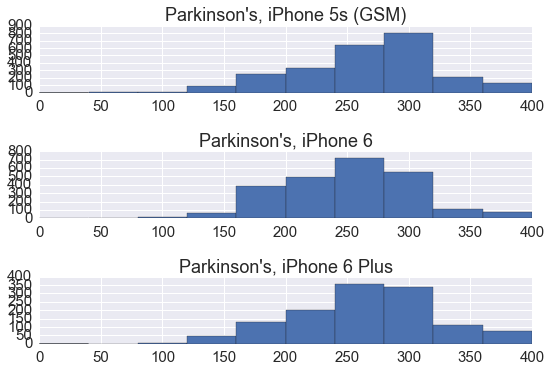

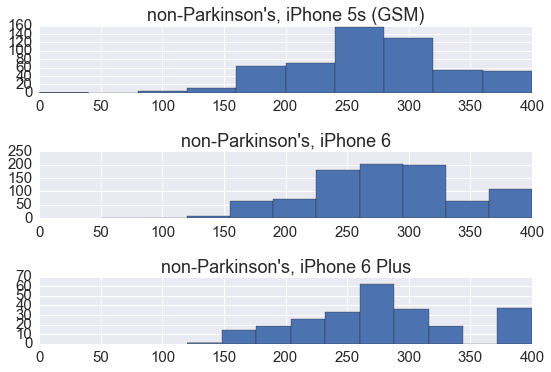

In [8]:
# compare these for parkinson's and non-parkinson's
# do on same plot too

# todo check if the scores are different, within parkinson's category, for phone type!

byphonePark = data[data.hasParkinsons==True].groupby('phoneInfo')
byphonenonPark = data[data.hasParkinsons==False].groupby('phoneInfo')

grouped = byphonePark
plt.figure()
numphones = len(grouped)
allphones = grouped.phoneInfo.unique()
for n, phone in enumerate(allphones):
    plt.subplot(len(allphones),1,n+1)
    data.game_score[grouped.groups[phone[0]]].hist()
    plt.title("Parkinson's, %s" % phone[0])
plt.tight_layout()

grouped = byphonenonPark
plt.figure()
numphones = len(grouped)
allphones = grouped.phoneInfo.unique()
for n, phone in enumerate(allphones):
    a = plt.subplot(len(allphones),1,n+1)
    data.game_score[grouped.groups[phone[0]]].hist()
    plt.title("non-Parkinson's, %s" % phone[0])
    a.set_xlim([0,400])
plt.tight_layout()

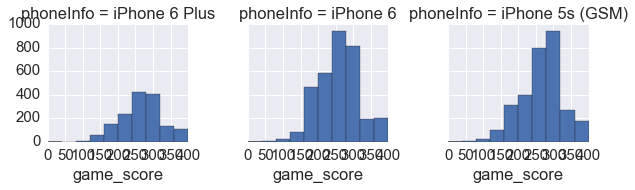

In [9]:
#sns.set(style="darkgrid", color_codes=True, font_scale=1.5)
#sns.set(style=color_codes=True, font_scale=1.5)
#sns.set(font_scale=1.5)

#sns.set(style="ticks", font_scale=1.5)#, color_codes=True)
g = sns.FacetGrid(data, col="phoneInfo")
g = g.map(plt.hist, "game_score")

#sns.set(style="ticks", font_scale=1.5, color_codes=True)
#g = sns.FacetGrid(data, col="phoneInfo")
#g = g.map(plt.hist, "game_score")


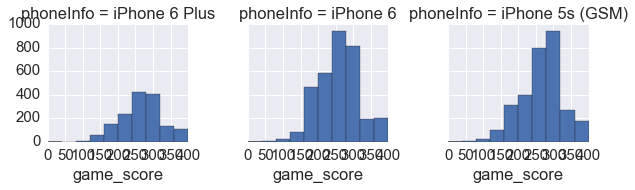

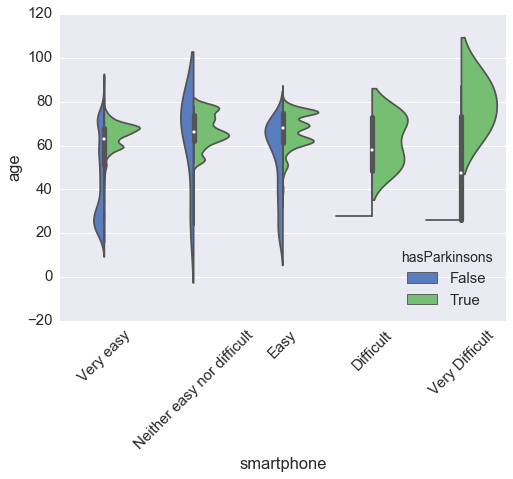

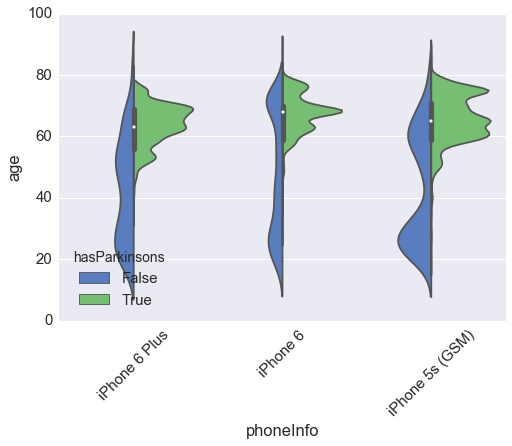

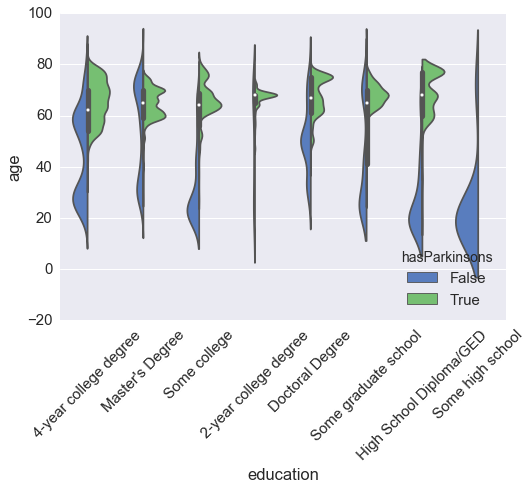

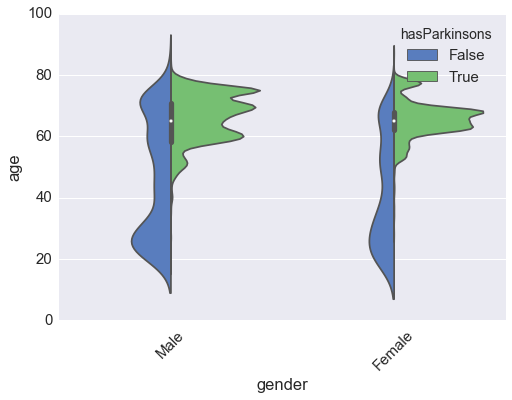

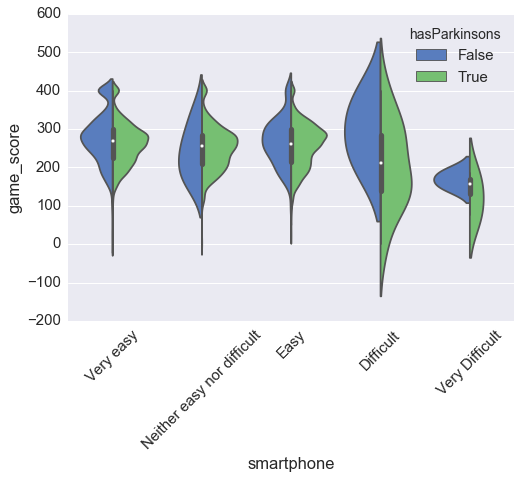

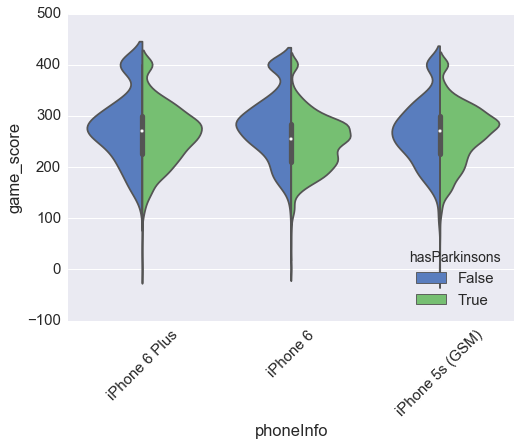

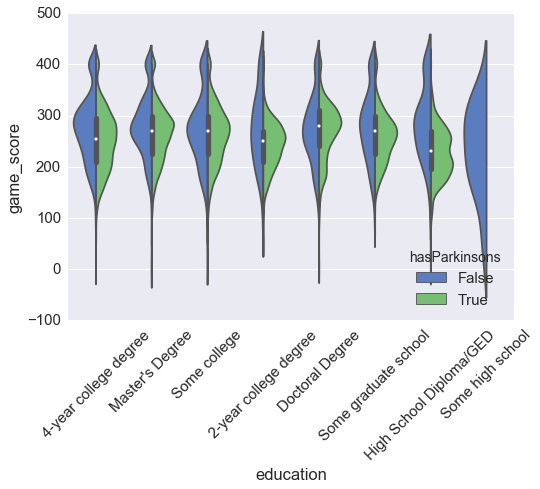

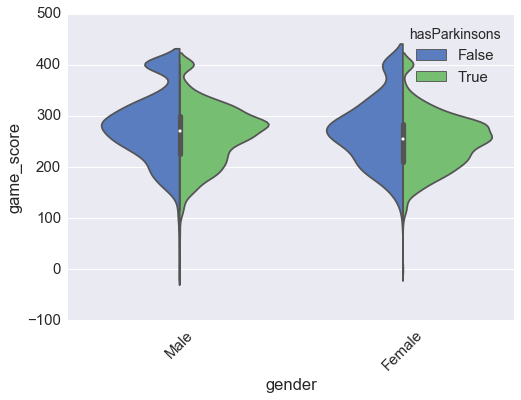

In [10]:
#sns.set(style="ticks", color_codes=True)

features_to_check_against_Parkinsons = ["game_score","age",
        "game_numFails", "phoneInfo", "education", "gender", 
        "phoneUsage", "smartphone"]
            
otherfeatures =  ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist']
#ax1 = sns.violinplot(x="phoneInfo", y="game_score", hue="hasParkinsons", data=data, palette="muted")#, split=True)    
#ax2 = sns.violinplot( y="game_score", hue="hasParkinsons", data=data, palette="muted", split=True)    

#features_to_check = ['phoneInfo, BLAST']
g = sns.FacetGrid(data, col="phoneInfo")
g = g.map(plt.hist, "game_score")

yvar = 'hasParkinsons'
catvars = ['smartphone', 'phoneInfo', 'education', 'gender']
freqvars = ['age', 'game_score']

for freqvar in freqvars:
    for catvar in catvars:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=data, palette="muted", split=True)    
        plt.xticks(rotation=45)



Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']


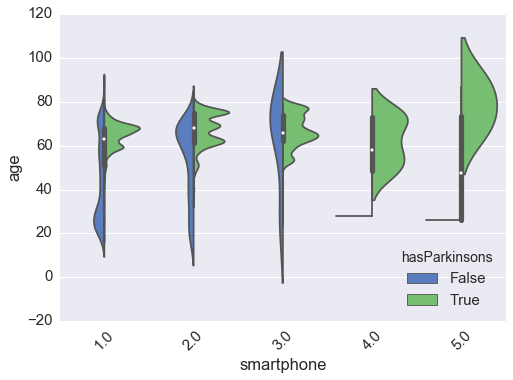

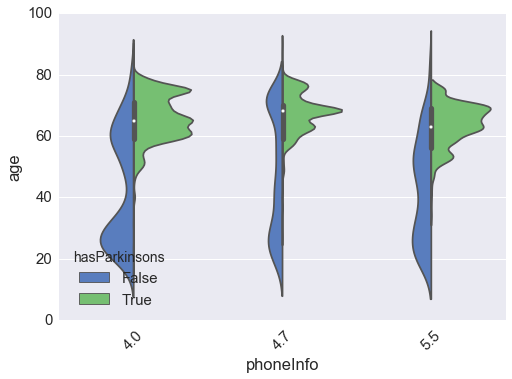

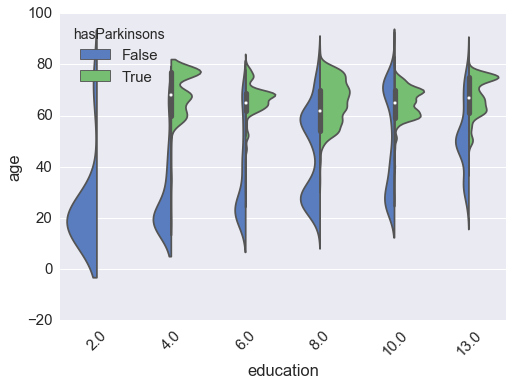

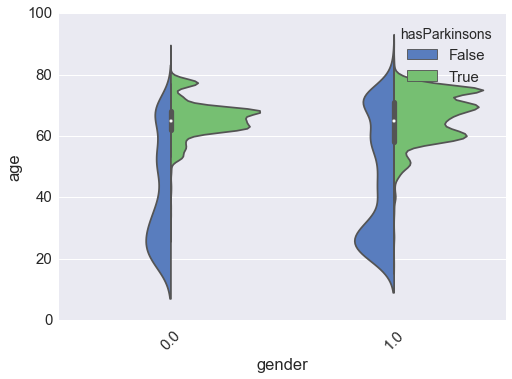

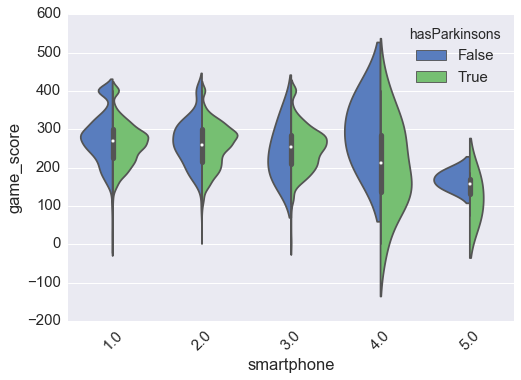

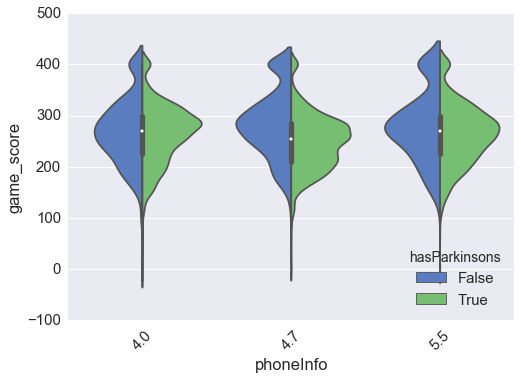

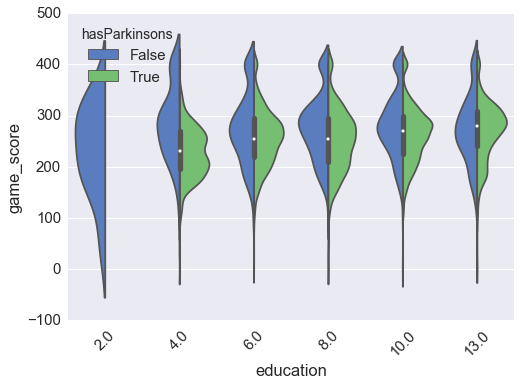

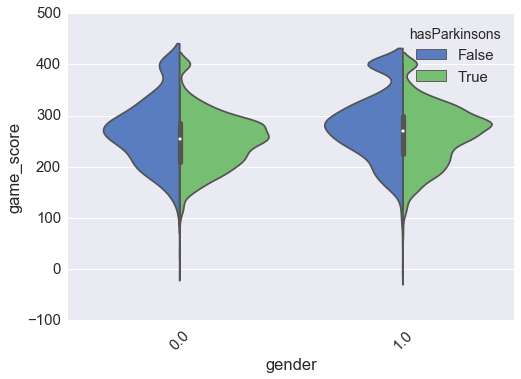

In [11]:
# revisualize after turning categorical-ordered into #'s:
features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features_df = data[features]
features_df = mt.convert_features_to_numbers(features_df)

yvar = 'hasParkinsons'
catvars = ['smartphone', 'phoneInfo', 'education', 'gender']
freqvars = ['age', 'game_score']

for freqvar in freqvars:
    for catvar in catvars:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=features_df, palette="muted", split=True)    
        plt.xticks(rotation=45)

        

## Troubleshoot the features from the game:

In [12]:
#data[['16_meansuccessfuldist','16_meanunsuccessfuldist']]

In [13]:
### look at one record where meansuccessfuldist > meanunsuccessfuldist -- that is wierd (might be a bug)
#rowidx = 7944
#print data['recordId'][rowidx]
#games = data['gamesdata'][rowidx]['games_by_sizes']
#games
##data['recordId'][rowidx]
## problem here... 

In [14]:
#games16 = games[16]
#avg_memory_features = mt.average_features_from_memory_games(games16)
#
##memory_features = mt.pull_features_from_memory_game(game)
##memory_features

#avg_memory_features
### It seems that the MemoryGameTouchSampleIsCorrect field is WRONG here!?, for the 1st result from game 16.

# Machine learning

### Imports & API calls:

In [15]:
from sklearn import linear_model
import sklearn
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import numpy as np
from sklearn.utils.validation import check_consistent_length, _num_samples
import sklearn.preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Pick & process features, 1st logistic regression:

In [16]:
##### define features:

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features_df = data[features]

features_df = mt.convert_features_to_numbers(features_df)
features_df = mt.move_col_to_end_of_df(features_df, 'hasParkinsons')

# do more processing here, in case of features with lots of nas

# drop na rows:
features_df = features_df.dropna()

# convert to matrices for machine learning:
labelcol = 'hasParkinsons'
X, y, X_names, y_name = mt.convert_features_df_to_X_and_y_for_machinelearning(features_df, labelcol)
    
###### perform logistic regression

# do cross validation manually:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# scale features:
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# create logistic regression model:
lr = LogisticRegression(C=1000.0, random_state=0)##
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
lr.fit(X_train_std, y_train)


###### assess regression performance:
lr.coef_
lr.intercept_ # this is the 0 coeff?
lr.fit(X_train_std, y_train)
print 'training accuracy:', lr.score(X_train_std, y_train)
print 'test accuracy:', lr.score(X_test_std, y_test) # suspiciously high..
lr.intercept_
lr.coef_ # only using 4 features.. which ones?
# mt.plot_decision_regions(X_combined_std, y_combined_std, classifier=lr, test_idx=range(len(X_train_std),len(X_combined_std)+1))
X_names_heavy = X_names[np.where(np.abs(lr.coef_) > 0.1)[1]]
Scoef = mt.convert_regression_coefs_to_pdSeries(lr.coef_, X_names)

print '\n'
print Scoef.sort_values()
#print lr.score
# tp / (tp + fn)

# look at sklearn.metrics

pass


Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 0.888564654386
test accuracy: 0.881327094853


phoneUsage      -0.726648
gender          -0.535846
education       -0.091916
game_score       0.030728
game_numFails    0.104056
phoneInfo        0.126661
age              1.523501
smartphone       1.527187
dtype: float64


### Try logistic regression, inputting the hasParkinsons column as a feature
#### (should give perfect prediction)

In [17]:

##### define features:
features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features_df = data[features]
features_df['hasParkinsons2'] = data['hasParkinsons']

features_df = mt.convert_features_to_numbers(features_df)
features_df = mt.move_col_to_end_of_df(features_df, 'hasParkinsons')

# do more processing here, in case of features with lots of nas

# drop na rows:
features_df = features_df.dropna()

# convert to matrices for machine learning:
labelcol = 'hasParkinsons'
X, y, X_names, y_name = mt.convert_features_df_to_X_and_y_for_machinelearning(features_df, labelcol)
    
###### perform logistic regression

# do cross validation manually:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# scale features:
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# create logistic regression model:
lr = LogisticRegression(C=1000.0, random_state=0)##
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
lr.fit(X_train_std, y_train)


###### assess regression performance:
lr.coef_
lr.intercept_ # this is the 0 coeff?
lr.fit(X_train_std, y_train)
print 'training accuracy:', lr.score(X_train_std, y_train)
print 'test accuracy:', lr.score(X_test_std, y_test) # suspiciously high..
lr.intercept_
lr.coef_ # only using 4 features.. which ones?
# mt.plot_decision_regions(X_combined_std, y_combined_std, classifier=lr, test_idx=range(len(X_train_std),len(X_combined_std)+1))
X_names_heavy = X_names[np.where(np.abs(lr.coef_) > 0.1)[1]]
Scoef = mt.convert_regression_coefs_to_pdSeries(lr.coef_, X_names)

print '\n'
print Scoef.sort_values()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 1.0
test accuracy: 1.0


phoneUsage       -0.116390
gender           -0.104257
game_score       -0.069913
education         0.006747
game_numFails     0.077573
phoneInfo         0.096486
smartphone        0.187908
age               0.625051
hasParkinsons2    9.381030
dtype: float64


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### that works well. good.

### Add memory features to model, & redo logistic regression

In [18]:
# How many nans in each column?
numnulls = data.isnull().sum()
pd.set_option('display.max_rows', len(numnulls))
numnulls.sort_values(inplace=True, ascending=True)
print 'Number of nulls per column:\n'
print numnulls

Number of nulls per column:

recordId                      0
played_game4                  0
gamesdata                     0
phoneInfo_demographic         0
appVersion_demographic        0
createdOn_demographic         0
recordId_demographic          0
game_records                  0
game_endDate                  0
game_records_txt              0
game_numFails                 0
game_numGames                 0
game_score                    0
phoneInfo                     0
appVersion                    0
createdOn                     0
healthCode                    0
game_startDate                0
hasParkinsons                 0
9_successful                  2
9_numsuccesses                2
9_meandist                    2
9_gamesize                    2
9_numunsuccesses              2
9_latency                     2
9_gamescore                   2
9_firstdist                   2
medTimepoint                  4
gender                        5
smartphone                    5
9_meanDt   

In [19]:
##### define features:
gamefeatures = ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist', '9_meanDt']
features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features = gamefeatures + features
#features = gamefeatures + ['game_score', 'hasParkinsons']

In [20]:
# transform features, etc.
features_df = data[features]

features_df = mt.convert_features_to_numbers(features_df)
features_df = mt.move_col_to_end_of_df(features_df, 'hasParkinsons')

# do more processing here, in case of features with lots of nas

# drop na rows:
features_df = features_df.dropna()

# convert to matrices for machine learning:
labelcol = 'hasParkinsons'
X, y, X_names, y_name = mt.convert_features_df_to_X_and_y_for_machinelearning(features_df, labelcol)
    
###### perform logistic regression

# do cross validation manually:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# scale features:
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# create logistic regression model:
lr = LogisticRegression(C=1000.0, random_state=0)##
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
lr.fit(X_train_std, y_train)


###### assess regression performance:
lr.coef_
lr.intercept_ # this is the 0 coeff?
lr.fit(X_train_std, y_train)
print 'training accuracy:', lr.score(X_train_std, y_train)
print 'test accuracy:', lr.score(X_test_std, y_test) # suspiciously high..
lr.intercept_
lr.coef_ # only using 4 features.. which ones?
# mt.plot_decision_regions(X_combined_std, y_combined_std, classifier=lr, test_idx=range(len(X_train_std),len(X_combined_std)+1))
X_names_heavy = X_names[np.where(np.abs(lr.coef_) > 0.1)[1]]
Scoef = mt.convert_regression_coefs_to_pdSeries(lr.coef_, X_names)

print '\n'
print Scoef.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 0.896513962402
test accuracy: 0.896126011069


9_gamescore        -1.019761
9_latency          -0.690115
gender             -0.675142
phoneUsage         -0.548219
education          -0.182102
game_score         -0.131353
game_numFails      -0.068393
9_gamesize          0.000000
9_firstdist         0.123148
phoneInfo           0.243323
9_numsuccesses      0.517643
9_meandist          0.671323
9_numunsuccesses    1.040649
age                 1.212418
smartphone          1.311676
9_meanDt            1.381738
9_successful        1.469330
dtype: float64


#### Barely affects results...

### Remove features until the model fails

In [21]:
##### define features:
gamefeatures = ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist', '9_meanDt']
#features = ["game_score","age","game_numFails", "phoneInfo","education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]

#features = gamefeatures + features
features = gamefeatures + ['game_score', 'hasParkinsons']
features.remove('9_successful')
features.remove('9_numunsuccesses')
features.remove('game_score')
features.remove('9_firstdist')
features.remove('9_meandist')
features.remove('9_latency')
features.remove('9_gamescore')
features.remove('9_numsuccesses')

features = ['gender', 'hasParkinsons']

features


['gender', 'hasParkinsons']

In [22]:
# transform features, etc.
features_df = data[features]

features_df = mt.convert_features_to_numbers(features_df)
features_df = mt.move_col_to_end_of_df(features_df, 'hasParkinsons')

# do more processing here, in case of features with lots of nas

# drop na rows:
features_df = features_df.dropna()

# convert to matrices for machine learning:
labelcol = 'hasParkinsons'
X, y, X_names, y_name = mt.convert_features_df_to_X_and_y_for_machinelearning(features_df, labelcol)
    
###### perform logistic regression

# do cross validation manually:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# scale features:
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# create logistic regression model:
lr = LogisticRegression(C=1000.0, random_state=0)##
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
lr.fit(X_train_std, y_train)


###### assess regression performance:
lr.coef_
lr.intercept_ # this is the 0 coeff?
lr.fit(X_train_std, y_train)
print 'training accuracy:', lr.score(X_train_std, y_train)
print 'test accuracy:', lr.score(X_test_std, y_test) # suspiciously high..
lr.intercept_
lr.coef_ # only using 4 features.. which ones?
# mt.plot_decision_regions(X_combined_std, y_combined_std, classifier=lr, test_idx=range(len(X_train_std),len(X_combined_std)+1))
X_names_heavy = X_names[np.where(np.abs(lr.coef_) > 0.1)[1]]
Scoef = mt.convert_regression_coefs_to_pdSeries(lr.coef_, X_names)

print '\n'
print Scoef.sort_values()

Features converted to numbers:

['gender']
training accuracy: 0.786494357481
test accuracy: 0.782590233546


gender   -0.511951
dtype: float64


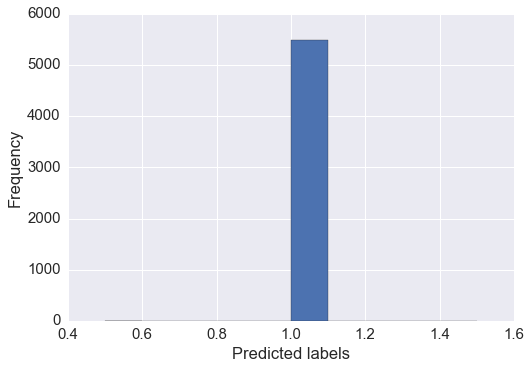

{True}

In [23]:
# look at predictions from model (are they all ones?):
predicted = lr.predict(X_train_std)
plt.hist(predicted)

plt.xlabel('Predicted labels')
plt.ylabel('Frequency')
plt.show()
#predicted.__class__

set(predicted)

# model is outputting all ones...###



### Visualize my features


In [24]:
##### define features:
gamefeatures = ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist']
features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons", '9_meanDt']
features = gamefeatures + features
features

['9_numsuccesses',
 '9_numunsuccesses',
 '9_gamesize',
 '9_meandist',
 '9_successful',
 '9_gamescore',
 '9_latency',
 '9_firstdist',
 'game_score',
 'age',
 'game_numFails',
 'phoneInfo',
 'education',
 'gender',
 'phoneUsage',
 'smartphone',
 'hasParkinsons',
 '9_meanDt']

In [25]:
data['smartphone'].unique()

array(['Very easy', 'Neither easy nor difficult', 'Easy', 'Difficult',
       'Very Difficult', nan], dtype=object)

In [26]:
# How many nans in each column?
mt.display_num_nulls_per_column(data)

Number of nulls per column:

recordId                      0
played_game4                  0
gamesdata                     0
phoneInfo_demographic         0
appVersion_demographic        0
createdOn_demographic         0
recordId_demographic          0
game_records                  0
game_endDate                  0
game_records_txt              0
game_numFails                 0
game_numGames                 0
game_score                    0
phoneInfo                     0
appVersion                    0
createdOn                     0
healthCode                    0
game_startDate                0
hasParkinsons                 0
9_successful                  2
9_numsuccesses                2
9_meandist                    2
9_gamesize                    2
9_numunsuccesses              2
9_latency                     2
9_gamescore                   2
9_firstdist                   2
medTimepoint                  4
gender                        5
smartphone                    5
9_meanDt   

### Try Random Forest:

In [27]:
##### define features:

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)       

# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

###### assess performance:
mod.fit(X_train, y_train)
print 'training accuracy:', mod.score(X_train, y_train)
print 'test accuracy:', mod.score(X_test, y_test) 
mat = mod.predict_proba(X_test)
#print mat[:,:5]
print mat.__class__
# coveariance?

# WORKS!!!!!!!

Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 0.999452854277
test accuracy: 0.976180348788
<type 'numpy.ndarray'>


#### Assess performance

[[ 461   30]
 [  26 1834]]
1860
1864


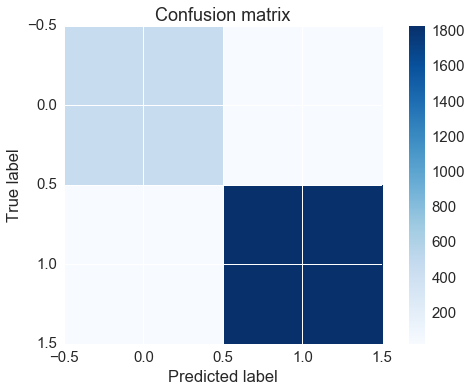

In [28]:
###### get predictions:
y_pred = mod.predict(X_test)
[y_test, y_pred]
sklearn.metrics.roc_auc_score(y_test, y_pred)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print cm
print sum(y_test)
print sum(y_pred)
sum(cm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#    tick_marks = np.arange(len(iris.target_names))
#    plt.xticks(tick_marks, iris.target_names, rotation=45)
#    plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#plot_confusion_matrix(cm_normalized)
plot_confusion_matrix(cm)

In [29]:
# which features matter?
fi = mod.feature_importances_
fi.__class__
S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()



game_numFails    0.014382
phoneUsage       0.025111
gender           0.043113
game_score       0.064215
education        0.065096
phoneInfo        0.075558
smartphone       0.123635
age              0.588890
Name: feature importances, dtype: float64


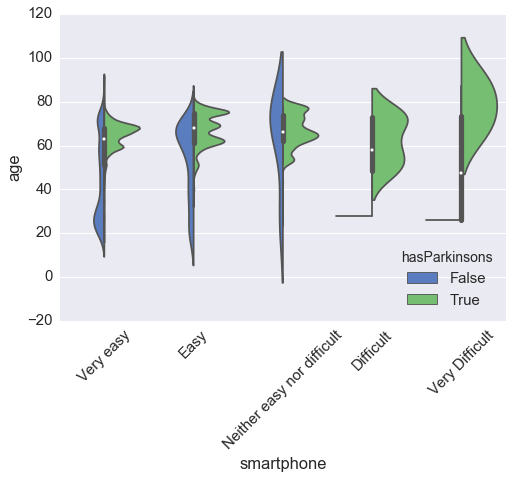

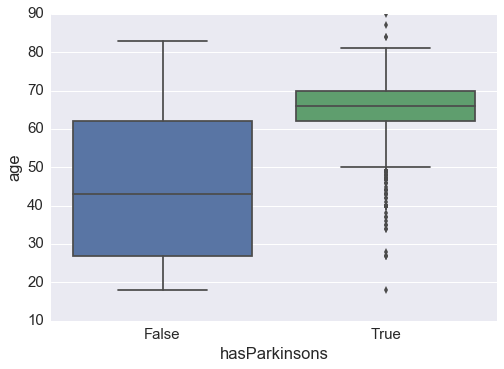

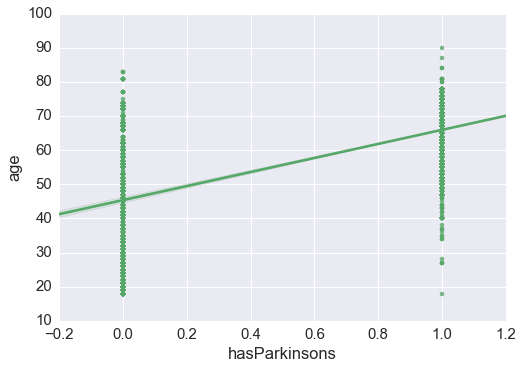

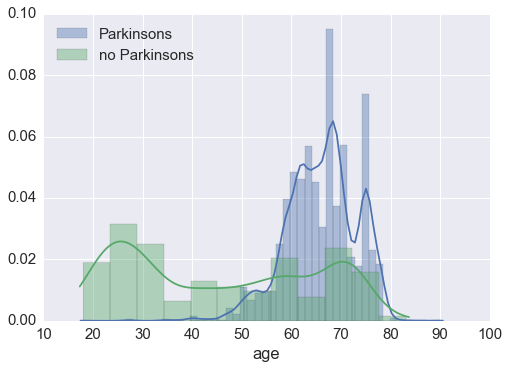

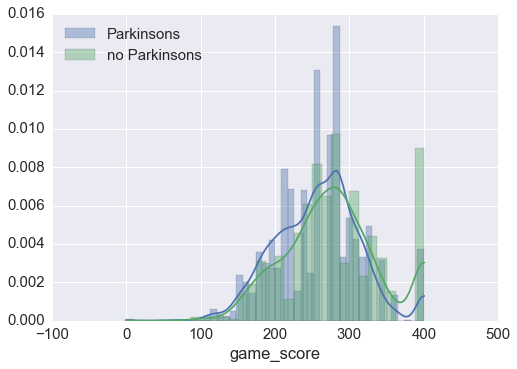

In [30]:

yvar = 'hasParkinsons'
catvar = 'smartphone'#, 'phoneInfo', 'education', 'gender']
freqvar = 'age'#, 'game_score']


order = ['Very easy', 'Easy','Neither easy nor difficult' , 'Difficult','Very Difficult']

#order = 
plt.figure()
ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=data, palette="muted", split=True, order=order)    
plt.xticks(rotation=45)


plt.figure()
ax = sns.boxplot(x="hasParkinsons", y="age", data=data)
#plt.figure()
#ax = sns.boxplot(x='hasParkinsons', y='smartphone', data=features_df)
plt.figure()
ax = sns.regplot(x=data['hasParkinsons'], y=data['age'], color="g")

plt.figure()
dp = data[data['hasParkinsons'] == True]
dn = data[data['hasParkinsons'] == False]
sns.distplot(dp['age'].dropna(), label='Parkinsons')
sns.distplot(dn['age'].dropna(), label='no Parkinsons')
plt.legend(loc=2)

#sns.set(font_scale=1.5)
plt.figure()
dp = data[data['hasParkinsons'] == True]
dn = data[data['hasParkinsons'] == False]
sns.distplot(dp['game_score'].dropna(), label='Parkinsons')
sns.distplot(dn['game_score'].dropna(), label='no Parkinsons')
plt.legend(loc=2)



In [31]:
# age is a confound - remove it & try again..?
# do simple regression to figure out the parkinsons corrected for age...?


In [32]:
# Do analysis per person 

['game_score', 'age', 'game_numFails', 'phoneInfo', 'education', 'gender', 'phoneUsage', 'smartphone', 'hasParkinsons']
[400, 90.0, 4, 'iPhone 6 Plus', 'Some high school', 'Male', 'true', 'Very easy', True]
400.0


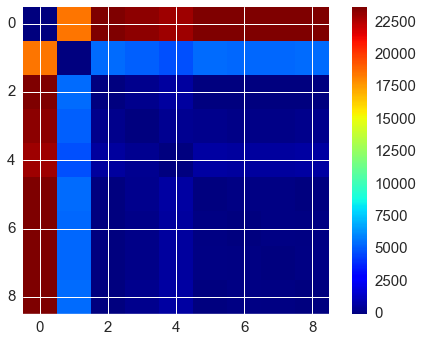

In [33]:
# distance matrix of X matrix (and y-column in there too):
import scipy.spatial.distance as dist
Xy = np.hstack((X, y.reshape(len(y),1)))
dd = dist.pdist(Xy.T, 'euclidean')
dd = dist.squareform(dd)
plt.imshow(dd, interpolation='none', cmap='jet')
plt.colorbar()

print features
print [data[f].max() for f in features]
print Xy.max()


In [34]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features.remove('age')
#features.remove('smartphone')
#features.remove('education')
#features.remove('gender')
#features.remove('phoneUsage')
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 0.908213440175
test accuracy: 0.866610025489
game_numFails    0.032332
phoneUsage       0.064463
gender           0.088559
phoneInfo        0.121947
education        0.177709
game_score       0.253343
smartphone       0.261647
Name: feature importances, dtype: float64


In [35]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features.remove('age')
features.remove('smartphone')
#features.remove('education')
#features.remove('gender')
#features.remove('phoneUsage')
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'education', 'phoneInfo']
training accuracy: 0.85849572027
test accuracy: 0.805012744265
game_numFails    0.050477
phoneUsage       0.079440
gender           0.090753
phoneInfo        0.155208
education        0.255153
game_score       0.368969
Name: feature importances, dtype: float64


[[ 209  263]
 [ 196 1686]]
1882
1949


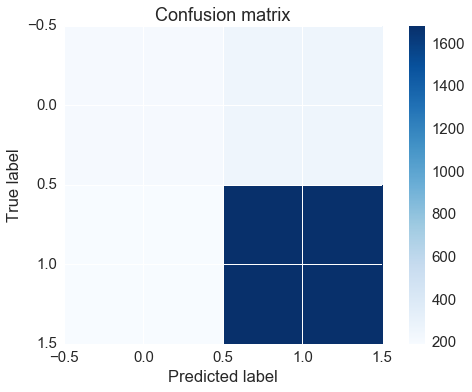

In [36]:
#  Confusion matrix:
#plot WWTF?@!
###### get predictions:
y_pred = mod2.predict(X_test)
[y_test, y_pred]
sklearn.metrics.roc_auc_score(y_test, y_pred)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print cm
print sum(y_test)
print sum(y_pred)
sum(cm)
plot_confusion_matrix(cm)

#monkey


In [37]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:
gamefeatures =  ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist', '9_meanDt']

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]
features.remove('age')
features.remove('smartphone')
features = features + gamefeatures
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'education', 'phoneInfo']
training accuracy: 1.0
test accuracy: 0.876275510204
9_gamesize          0.000000
9_successful        0.006321
9_numunsuccesses    0.006396
9_numsuccesses      0.014987
9_gamescore         0.015300
game_numFails       0.022459
phoneUsage          0.026128
gender              0.046727
phoneInfo           0.056782
education           0.070695
game_score          0.075144
9_firstdist         0.108163
9_meandist          0.124109
9_latency           0.124924
9_meanDt            0.301864
Name: feature importances, dtype: float64


In [38]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:
features = ['hasParkinsons', '9_latency', '9_meandist', '9_firstdist','game_score','education', '9_meanDt']
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['education']
training accuracy: 1.0
test accuracy: 0.828656462585
education      0.061991
game_score     0.105053
9_firstdist    0.147760
9_latency      0.154879
9_meandist     0.164173
9_meanDt       0.366144
Name: feature importances, dtype: float64


In [39]:
#

In [40]:
# LOOK AT INDIVIDUALS, TAKING MEDICINE VS NOT.

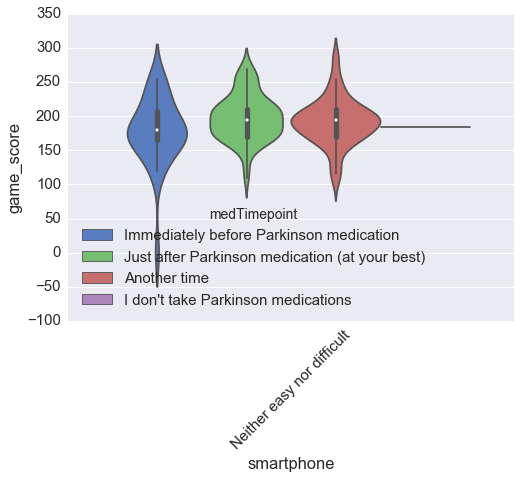

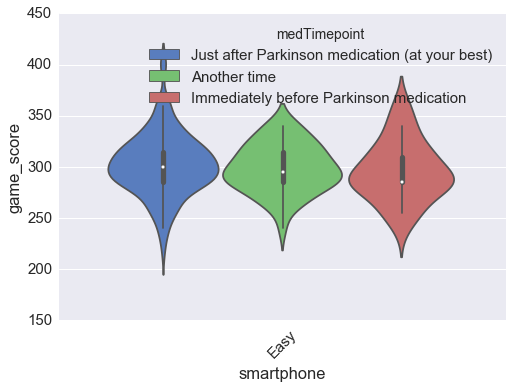

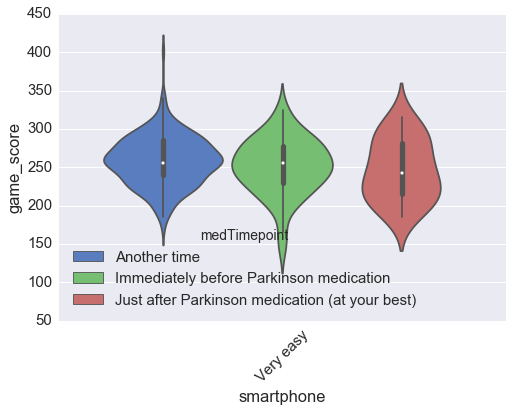

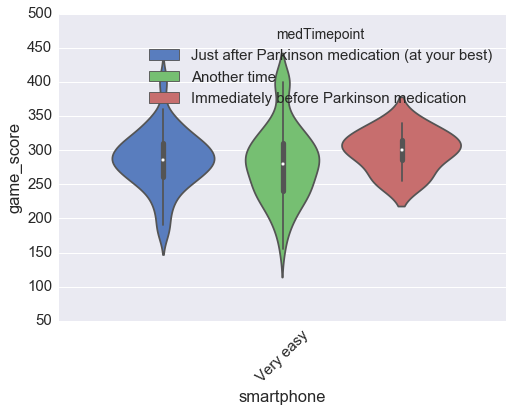

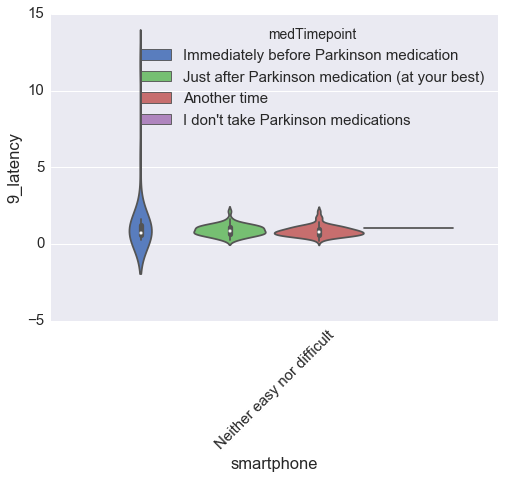

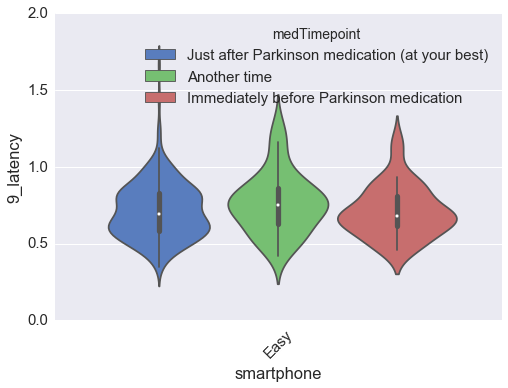

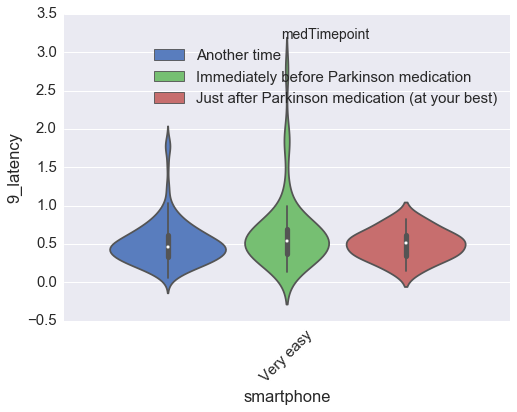

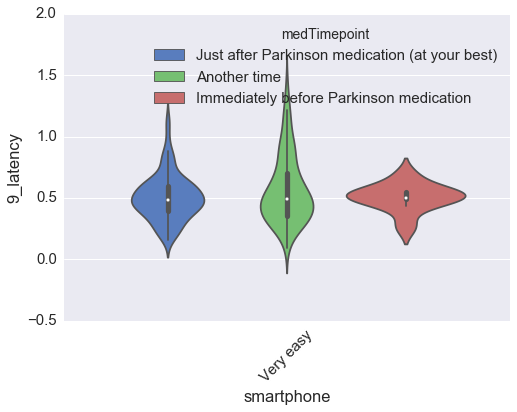

In [41]:
#individuals = data.groupby('healthCode')
individuals = data.loc[data['hasParkinsons']==True].groupby('healthCode')

#yvar = 'hasParkinsons'
#catvars = ['smartphone', 'phoneInfo', 'education', 'gender']
#freqvars = ['age', 'game_score']
yvar = 'medTimepoint'
catvar = 'smartphone'
freqvar = 'game_score'
for id, df in individuals:
    if len(df) > 150:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=df, palette="muted")#, split=True)    
        plt.xticks(rotation=45)

yvar = 'medTimepoint'
catvar = 'smartphone'
freqvar = '9_latency'
for id, df in individuals:
    if len(df) > 150:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=df, palette="muted")#, split=True)    
        plt.xticks(rotation=45)



        
        
    

In [42]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:
gamefeatures =  ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist', '9_meanDt']

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]

features = gamefeatures + features
features.remove('9_numunsuccesses')
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
training accuracy: 1.0
test accuracy: 0.96509152831
9_gamesize        0.000000
9_successful      0.003065
9_numsuccesses    0.006809
9_gamescore       0.006916
game_numFails     0.010390
phoneUsage        0.015371
game_score        0.031141
gender            0.032785
education         0.037538
9_firstdist       0.042858
phoneInfo         0.050050
9_latency         0.053075
9_meandist        0.053160
smartphone        0.100071
9_meanDt          0.139037
age               0.417734
Name: feature importances, dtype: float64


['9_numsuccesses', '9_gamesize', '9_meandist', '9_successful', '9_gamescore', '9_latency', '9_firstdist', '9_meanDt', 'game_score', 'age', 'game_numFails', 'phoneInfo', 'education', 'gender', 'phoneUsage', 'smartphone', 'hasParkinsons']
[3.6666666666666665, 9.0, 206.77473014123353, 1.0, 82.5, 11.75321187500958, 204.88106305854623, 2.6244784392341298, 400, 90.0, 4, 'iPhone 6 Plus', 'Some high school', 'Male', 'true', 'Very easy', True]
400.0


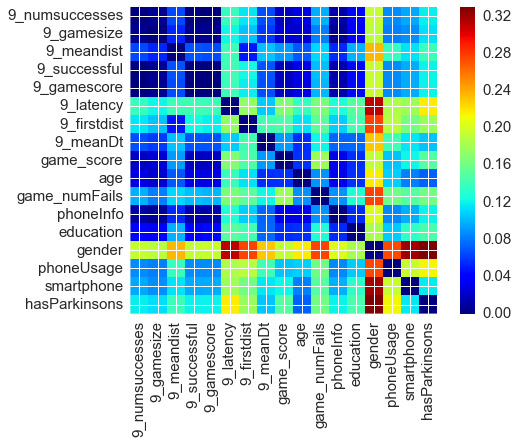

In [43]:
# distance matrix of X matrix (and y-column in there too):
import scipy.spatial.distance as dist


Xy = np.hstack((X, y.reshape(len(y),1)))
dd = dist.pdist(Xy.T, 'cosine')
dd = dist.squareform(dd)
plt.imshow(dd, interpolation='none', cmap='jet')
plt.colorbar()
plt.xticks(rotation=45)
plt.yticks(range(len(features)), features)#, rotation='vertical')
plt.xticks(range(len(features)), features, rotation='vertical')
print features
print [data[f].max() for f in features]
print Xy.max()



In [44]:
# redo random forest with less features.. (BREAK THE MODEL)
##### define features:
gamefeatures =  ['9_numsuccesses', '9_numunsuccesses',
                '9_gamesize', '9_meandist', '9_successful',
                '9_gamescore', '9_latency', '9_firstdist', '9_meanDt',
                '16_numsuccesses', '16_numunsuccesses',
                '16_gamesize', '16_meandist', '16_successful',
                '16_gamescore', '16_latency', '16_firstdist', '16_meanDt']

features = ["game_score","age","game_numFails", "phoneInfo",
    "education", "gender", "phoneUsage", "smartphone", "hasParkinsons"]

features = gamefeatures + features
features.remove('9_numunsuccesses')
features.remove('16_numunsuccesses')
labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  
print 'There are now %s samples, after filtering nas' % len(y)

# create model:
mod2 = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod2.fit(X_train, y_train)

###### assess performance:
mod2.fit(X_train, y_train)
print 'training accuracy:', mod2.score(X_train, y_train)
print 'test accuracy:', mod2.score(X_test, y_test) 
mat = mod2.predict_proba(X_test)
#print mat
# which features matter?
fi = mod2.feature_importances_
mod2.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

['gender', 'phoneUsage', 'smartphone', 'education', 'phoneInfo']
There are now 7551 samples, after filtering nas
training accuracy: 1.0
test accuracy: 0.947484554281
9_gamesize         0.000000
16_gamesize        0.000000
9_successful       0.002394
9_gamescore        0.004836
9_numsuccesses     0.005151
game_numFails      0.005299
16_successful      0.007761
phoneUsage         0.012039
16_numsuccesses    0.017223
game_score         0.019093
16_gamescore       0.019306
gender             0.027061
education          0.027485
9_firstdist        0.027773
phoneInfo          0.029062
16_firstdist       0.030903
16_latency         0.036288
9_latency          0.037364
9_meandist         0.038207
16_meandist        0.041143
smartphone         0.092524
9_meanDt           0.109548
16_meanDt          0.114528
age                0.295012
Name: feature importances, dtype: float64


['9_numsuccesses', '9_gamesize', '9_meandist', '9_successful', '9_gamescore', '9_latency', '9_firstdist', '9_meanDt', '16_numsuccesses', '16_gamesize', '16_meandist', '16_successful', '16_gamescore', '16_latency', '16_firstdist', '16_meanDt', 'game_score', 'age', 'game_numFails', 'phoneInfo', 'education', 'gender', 'phoneUsage', 'smartphone', 'hasParkinsons']
[3.6666666666666665, 9.0, 206.77473014123353, 1.0, 82.5, 11.75321187500958, 204.88106305854623, 2.6244784392341298, 6.0, 16.0, 109.90672012692281, 1.0, 137.5, 16.05716520833084, 303.9111712326482, 6.5116739791628797, 400, 90.0, 4, 'iPhone 6 Plus', 'Some high school', 'Male', 'true', 'Very easy', True]
400.0


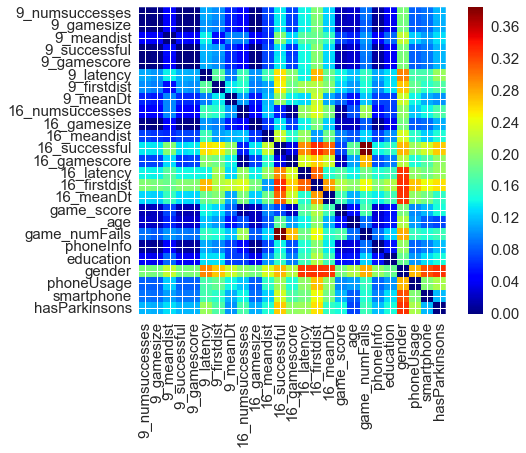

In [45]:
# distance matrix of X matrix (and y-column in there too):
import scipy.spatial.distance as dist


Xy = np.hstack((X, y.reshape(len(y),1)))
dd = dist.pdist(Xy.T, 'cosine')
dd = dist.squareform(dd)
plt.imshow(dd, interpolation='none', cmap='jet')
plt.colorbar()
plt.xticks(rotation=45)
plt.yticks(range(len(features)), features)#, rotation='vertical')
plt.xticks(range(len(features)), features, rotation='vertical')
print features
print [data[f].max() for f in features]

print Xy.max()

Features converted to numbers:

[]


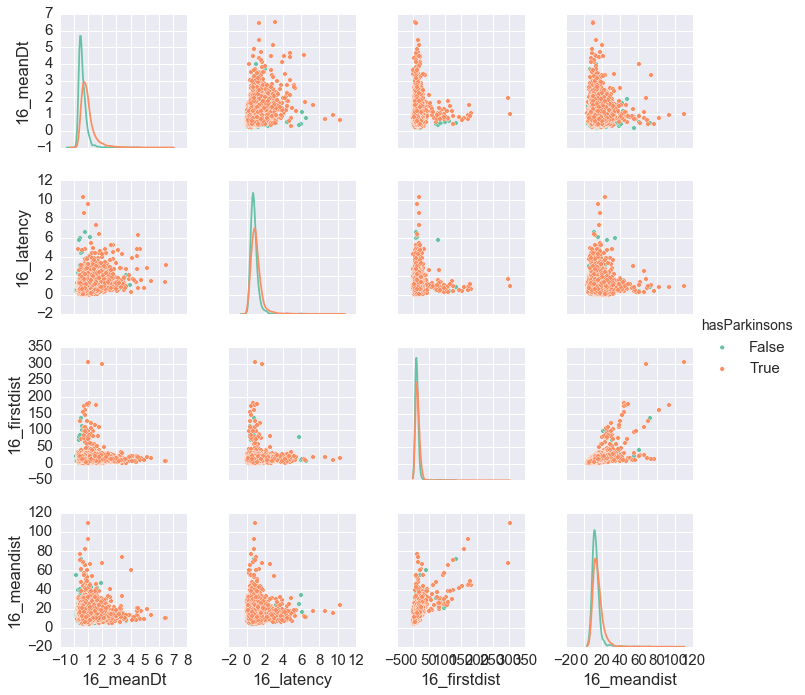

In [46]:
#featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
#features_df = data[["game_score",'16_gamescore','hasParkinsons']]
features_df = data[['16_meanDt','16_latency', '16_firstdist', '16_meandist', 'hasParkinsons']]
plotfeatures = ['16_meanDt','16_latency', '16_firstdist', '16_meandist']
features_df = mt.convert_features_to_numbers(features_df).dropna()
g = sns.pairplot(features_df, x_vars=plotfeatures,y_vars=plotfeatures,hue="hasParkinsons", palette="Set2", diag_kind="kde", markers="o")#, size=2.5)




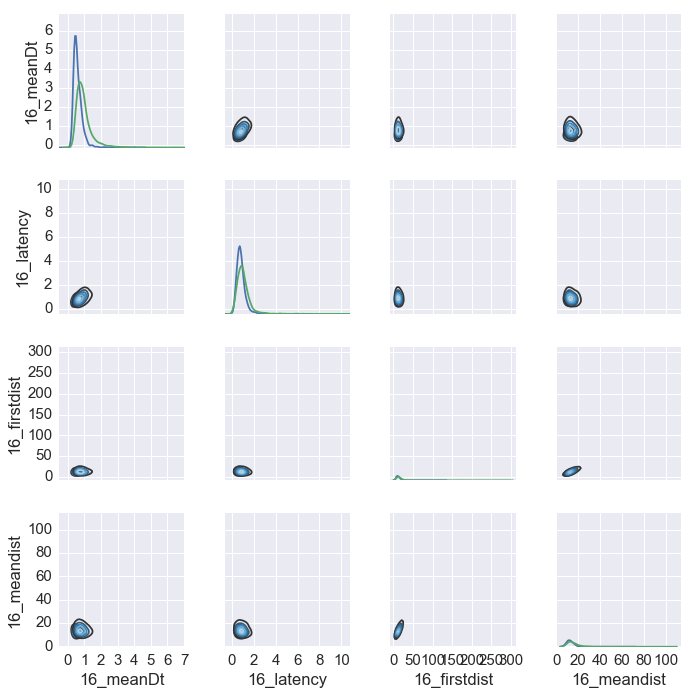

In [47]:
g = sns.PairGrid(features_df,x_vars=plotfeatures,y_vars=plotfeatures,hue="hasParkinsons")
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)


Features converted to numbers:

[]


/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


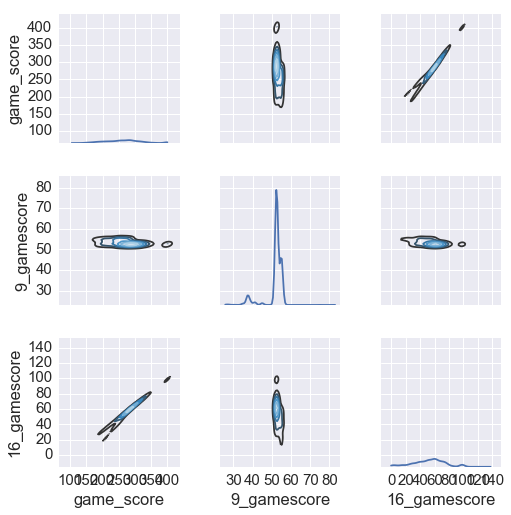

In [48]:
#featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
features_df = data[["game_score", '9_gamescore', '16_gamescore']]
features_df = mt.convert_features_to_numbers(features_df).dropna()
g = mt.squaregridhistplot(features_df)



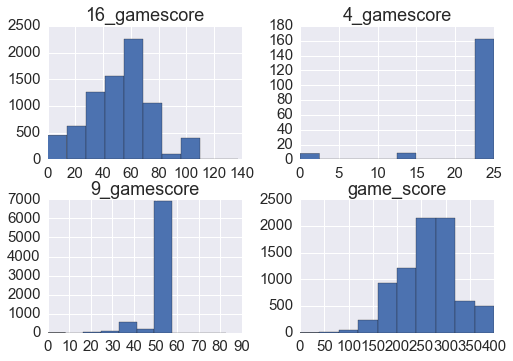

In [49]:
features_df = data[['4_gamescore', '9_gamescore', '16_gamescore', "game_score" ]]
features_df.hist()
pass

Features converted to numbers:

[]


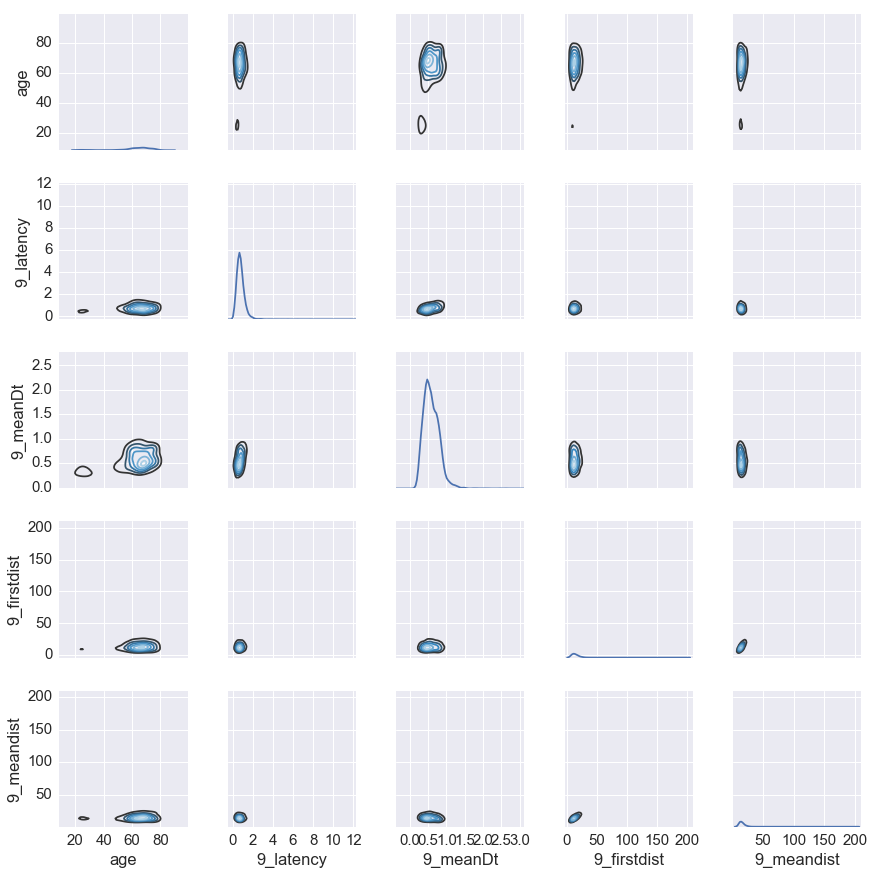

In [50]:
#featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
featurestoPlot = ["age", '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
features_df = data[featurestoPlot]
features_df = mt.convert_features_to_numbers(features_df).dropna()
g = mt.squaregridhistplot(features_df)
pass

In [51]:
# redo random forest with all game features.. 

##### define features:
demographicfeatures = ['gender','education','employment']
gamefeatures = [
    'game_numFails',
    'game_score',
    'game_numGames',
    '9_numsuccesses',
    '9_numunsuccesses',
    '9_meandist',
    '9_successful',
    '9_gamescore',
    '9_latency',
    '9_firstdist',
    '9_meanDt',
    '9_meansuccessfuldist',
    '16_firstdist',
    '16_meandist',
    '16_numsuccesses',
    '16_gamescore',
    '16_latency',
    '16_numunsuccesses',
    '16_successful',
    '16_meanDt',
    '16_meansuccessfuldist',
    '16_meanunsuccessfuldist']
confoundfeatures = ['smartphone','age']

features = gamefeatures
features.append('hasParkinsons')

labelcol = 'hasParkinsons'
features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(data, features, labelcol)  

# create model:
mod = RandomForestClassifier(n_estimators=100)
mod.fit(X_train, y_train)

###### assess performance:
mod.fit(X_train, y_train)
print 'training accuracy:', mod.score(X_train, y_train)
print 'test accuracy:', mod.score(X_test, y_test) 
mat = mod.predict_proba(X_test)
#print mat
# which features matter?
fi = mod.feature_importances_
mod.feature_importances_

S = pd.Series(fi, index=X_names, name="feature importances")
print S.sort_values()

Features converted to numbers:

[]
training accuracy: 1.0
test accuracy: 0.852153110048
game_numGames              0.000319
9_successful               0.002337
9_numunsuccesses           0.002710
game_numFails              0.003808
9_gamescore                0.006663
9_numsuccesses             0.007045
16_successful              0.008672
16_numunsuccesses          0.008818
16_numsuccesses            0.025346
game_score                 0.029196
16_gamescore               0.029854
9_meansuccessfuldist       0.051918
9_meandist                 0.053249
16_meanunsuccessfuldist    0.055013
16_firstdist               0.055096
9_firstdist                0.055482
16_latency                 0.056847
16_meansuccessfuldist      0.062587
16_meandist                0.063735
9_latency                  0.067487
16_meanDt                  0.171232
9_meanDt                   0.182584
Name: feature importances, dtype: float64


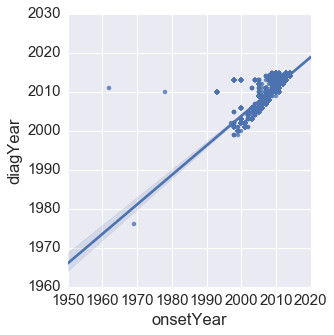

In [52]:
# correlation of onset year and diagnosis year
x='onsetYear'
y='diagYear'
d = data[[x, y]].dropna()
#sns.jointplot(x="onsetYear", y="diagYear", data=d, kind="kde")

lm = sns.lmplot(x,y,d)
#axes = lm.axes
#axes[0,0].set_ylim(1990,)

### Explore feature relationships:

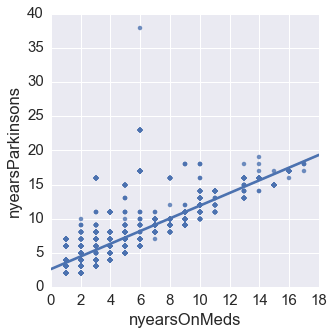

In [53]:
from numpy import nan
# correlation of medication start year versus years parkinsons
x='nyearsOnMeds'
y='nyearsParkinsons'
df = data[[x, y]].dropna()
lm = sns.lmplot(x,y,df)

In [54]:
# load feature categories
fcats = mt.define_feature_categories()
fcats

Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


{'demographic': ['age', 'gender', 'education'],
 'game': ['game_numFails',
  'game_score',
  'game_numGames',
  '9_numsuccesses',
  '9_numunsuccesses',
  '9_meandist',
  '9_successful',
  '9_gamescore',
  '9_latency',
  '9_firstdist',
  '9_meanDt',
  '9_meansuccessfuldist',
  '16_firstdist',
  '16_meandist',
  '16_numsuccesses',
  '16_gamescore',
  '16_latency',
  '16_numunsuccesses',
  '16_successful',
  '16_meanDt',
  '16_meansuccessfuldist',
  'played_game4'],
 'output': ['hasParkinsons',
  'medTimepoint',
  'brainStim',
  'surgery',
  'nyearsOnMeds',
  'nyearsOffMeds',
  'nyearsParkinsons'],
 'person': ['healthCode'],
 'phone': ['phoneInfo', 'smartphone'],
 'time': ['game_endDate', 'createdOn', 'game_startDate']}

In [55]:
# do an all vs. has parkinsons ttest:
features = fcats['game'] + fcats['demographic'] + fcats['output']
features.remove('medTimepoint')
features_df = data[features]
features_df = mt.convert_features_to_numbers(features_df)
features_df.head(2)

ttestresults = mt.column_ttests(features_df, 'hasParkinsons')
ttestresults



Features converted to numbers:

['gender', 'education']


,pvals,tstats
age,0.000000e+00,-69.068114
9_meanDt,9.147164e-284,-37.537540
16_meanDt,4.482584e-168,-28.345833
16_meansuccessfuldist,9.593696e-69,-17.702716
gender,2.646628e-55,15.788229
9_meansuccessfuldist,9.954155e-48,-14.611920
16_meandist,2.509532e-44,-14.055256
brainStim,6.543204e-40,-13.298607
9_meandist,4.565962e-37,-12.786456
9_firstdist,7.677056e-37,-12.745159


In [56]:
# obviously, age is a huge confound. gender is too?!

### Redo machine learning after dealing with age confound:

#### Resample non-parkinsons to same age distribution as Parkinsons:

RanksumsResult(statistic=-1.340996669464035, pvalue=0.17992153394191801)


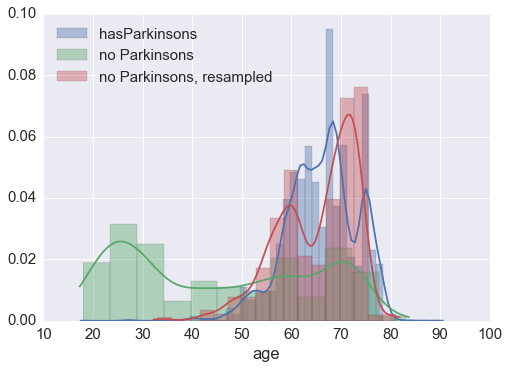

In [57]:
# resample non-Park to same age distribution as Parkinsons:
df = features_df
distcol = 'age'
splitcol = 'hasParkinsons'
splitVal_resample = False
splitVal_guide = True
nbins = 10
nResamples = 600
df_resampled, df_guide, df_resample = mt.resample_to_match_distribution(df, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
df_resampled_np = df_resampled
df_Parkinsons = df_guide
df_np = df_resample

sns.distplot(df_guide[distcol].dropna(), label='hasParkinsons')
sns.distplot(df_resample[distcol].dropna(), label='no Parkinsons')
sns.distplot(df_resampled[distcol].dropna(), label='no Parkinsons, resampled')
plt.legend(loc=2)

x = df_resampled[distcol].dropna().values
y = df_guide[distcol].dropna().values
p2 = ranksums(x, y)
print p2




RanksumsResult(statistic=-4.8707209555647424, pvalue=1.1119178010831924e-06)


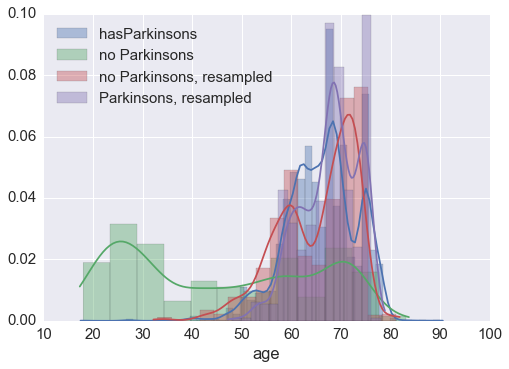

In [58]:
# resample Park to the resampled non-Park for sample balancing:
# resample non-Park to same age distribution as Parkinsons:
df = df_resampled_np.append(df_Parkinsons)
distcol = 'age'
splitcol = 'hasParkinsons'
splitVal_resample = True
splitVal_guide = False
df_resampled, df_guide, df_resample = mt.resample_to_match_distribution(df, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
df_resampled_Park = df_resampled


sns.distplot(df_Parkinsons[distcol].dropna(), label='hasParkinsons')
sns.distplot(df_np[distcol].dropna(), label='no Parkinsons')
sns.distplot(df_resampled_np[distcol].dropna(), label='no Parkinsons, resampled')
sns.distplot(df_resampled_Park[distcol].dropna(), label='Parkinsons, resampled')
plt.legend(loc=2)

x = df_resampled_np[distcol].dropna().values
y = df_resampled_Park[distcol].dropna().values
p2 = ranksums(x, y)
print p2


training accuracy: 1.0
test accuracy: 0.765536723164
num actual positives = 588
num actual negatives = 590
random accuracy would be 0.499151103565


feature importances:
game_numGames            0.000000
played_game4             0.000274
9_numunsuccesses         0.001967
9_successful             0.002760
game_numFails            0.007136
9_gamescore              0.008139
9_numsuccesses           0.008505
16_successful            0.010961
16_numunsuccesses        0.012328
16_numsuccesses          0.027964
game_score               0.033341
16_gamescore             0.035772
16_firstdist             0.055904
16_latency               0.063331
9_firstdist              0.063934
9_meansuccessfuldist     0.064677
9_meandist               0.068716
16_meansuccessfuldist    0.076791
9_latency                0.079108
16_meandist              0.085253
16_meanDt                0.127944
9_meanDt                 0.165195
Name: feature importances, dtype: float64
[[135  32]
 [ 51 136]]


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


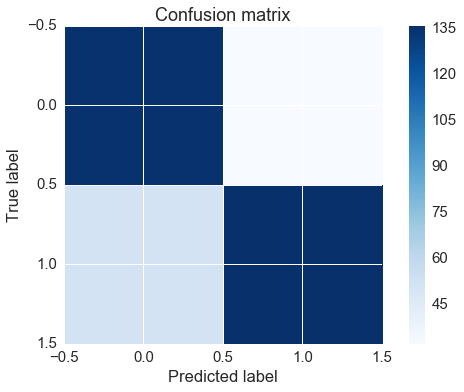

In [59]:
### Redo machine learning with these sets:
df = df_resampled_np.append(df_resampled_Park)
features = fcats['game'] + ['hasParkinsons']# + fcats['demographic'] + fcats['output']
#features = ['9_firstdist', '9_meansuccessfuldist', '16_meansuccessfuldist', '9_latency', '16_meanDt', '9_meanDt', 'hasParkinsons']
#features = [ '16_meansuccessfuldist', '9_latency', '16_meanDt', '9_meanDt', 'hasParkinsons']

labelcol = 'hasParkinsons'
#mt.display_num_nulls_per_column(df[features])

features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, stdsc, X_train_std, X_test_std, X_combined_std, y_combined = mt.prep_memory_features_for_machine_learning(df, features, labelcol, convert_features_to_nums=False)       


# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

###### assess performance:
mod.fit(X_train, y_train)
print 'training accuracy:', mod.score(X_train, y_train)
print 'test accuracy:', mod.score(X_test, y_test) 
print 'num actual positives = %s' % sum(y)
print 'num actual negatives = %s' % (len(y) - sum(y))
print 'random accuracy would be %s' % (float(sum(y))/len(y))
print '\n'

# which features matter?
#print mat
mat = mod.predict_proba(X_test)

print 'feature importances:'
S = pd.Series(mod.feature_importances_, index=X_names, name="feature importances")
print S.sort_values()


#  Confusion matrix:
y_pred = mod.predict(X_test)
sklearn.metrics.roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print cm
plot_confusion_matrix(cm)


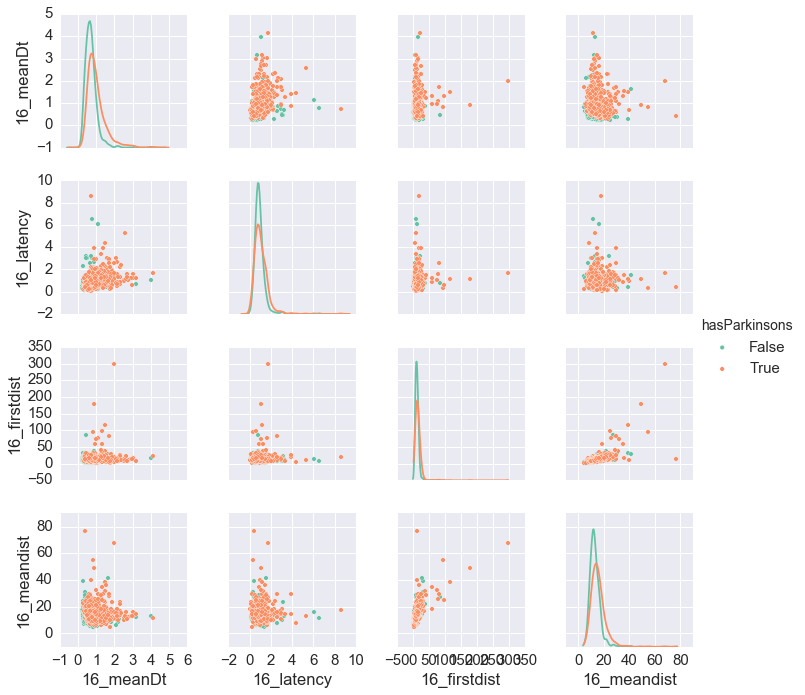

In [60]:
# visualize this new dataset (resampled):

#featurestoPlot = ["age", "game_score", '9_gamescore', '9_latency', '9_meanDt', '9_firstdist', '9_meandist']
#features_df = data[["game_score",'16_gamescore','hasParkinsons']]
fplot = features_df[['16_meanDt','16_latency', '16_firstdist', '16_meandist', 'hasParkinsons']]
plotfeatures = ['16_meanDt','16_latency', '16_firstdist', '16_meandist']
#fplot = fplot.dropna()
g = sns.pairplot(fplot, x_vars=plotfeatures,y_vars=plotfeatures,hue="hasParkinsons", palette="Set2", diag_kind="kde", markers="o")#, size=2.5)



In [61]:
# To Do:

In [62]:
# try logistic regression, with l1 (lasso) (minimize # features)

In [63]:
# do pca of outputs, and see if we can be more predictive

In [64]:
# split data by person and check on drugs vs not on drugs (what is predictive)

In [65]:
# time series analysis of indiv. patients, looking at the yes and no data?

In [66]:
# symptom variance individual patients plot?

In [67]:
# run rand forest with all in-game features & sample balancing but not correction for age
